In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import collections

## Which vep tool should I use? 
First, I read in the missense mutation effect predictions from dbNSFP for chd and control data.

In [36]:
chd_score_dict = {}

### VEP scores from dbNSFP for dnv in CHD cohort
with open('data/chd.missense.scores.08_21_20.txt', 'r') as chd_scores_f:
    chd_scores_reader = csv.reader(chd_scores_f, delimiter = '\t')
    header = next(chd_scores_reader)
    
    for row in chd_scores_reader:
        chrom = row[0]
        pos = row[1]
        ref = row[2]
        alt = row[3]
        
        effects = []
        canon_index = row[10].split(';').index('YES')
        genename = row[8].split(';')[canon_index]

        effects.append(genename)
        effects.append(row[9].split(';')[canon_index]) # amino acid
        for i in range(11,39):

            if len(row[i].split(';')) == 1:
                if row[i] == '.':
                    score = None
                else:
                    score = float(row[i])
            else:
                scores = row[i].split(';')
                # Only PROVEAN has lower scores meaning damaging
                if header[i] != 'PROVEAN_score':
                    max_score = float('-inf')
                    for j in scores:
                        if (j) != '.':
                            if float(j) > max_score: 
                                max_score = float(j)
                    if max_score == float('-inf'):
                        score = None
                    else:
                        score = max_score
                else:
                    min_score = float('inf')
                    for j in scores:
                        if (j) != '.':
                            if float(j) < min_score: 
                                min_score = float(j)
                    if min_score == float('inf'):
                        score = None
                    else:
                        score = min_score

            effects.append(score)
        chd_score_dict[(chrom,pos,ref,alt)] = effects

In [37]:
control_score_hg19_dict = {}
control_score_hg38_dict = {}
mis_hg19_to_hg38_dict = {}

### VEP scores from dbNSFP for dnv in autism cohort controls
with open('data/control.missense.scores.08_21_20.txt', 'r') as control_scores_f:
    control_scores_reader = csv.reader(control_scores_f, delimiter = '\t')
    header = next(control_scores_reader)
    new_header = ['genename', 'effects', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_rankscore', 'MutationAssessor_score', 'MutationAssessor_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST4_score', 'VEST4_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'REVEL_score', 'REVEL_rankscore', 'MPC_score', 'MPC_rankscore', 'PrimateAI_score', 'PrimateAI_rankscore', 'DEOGEN2_score', 'DEOGEN2_rankscore', 'CADD_raw', 'CADD_raw_rankscore']
    for row in control_scores_reader:
        chrom = row[6]
        pos = row[7]
        ref = row[2]
        alt = row[3]
        
        hg38_chrom = row[0]
        hg38_pos = row[1]
        
        effects = []
        canon_index = row[10].split(';').index('YES')
        genename = row[8].split(';')[canon_index]

        effects.append(genename)
        effects.append(row[9].split(';')[canon_index]) # amino acid

        for i in range(11,39):
            if len(row[i].split(';')) == 1:
                if row[i] == '.':
                    score = None
                else:
                    score = float(row[i])
            else:
                #score = row[i].split(';')[canon_index]
                scores = row[i].split(';')
                # Only PROVEAN has lower scores meaning damaging
                if header[i] != 'PROVEAN_score':
                    max_score = float('-inf')
                    for j in scores:
                        if (j) != '.':
                            if float(j) > max_score: 
                                max_score = float(j)
                    if max_score == float('-inf'):
                        score = None
                    else:
                        score = max_score
                else:
                    min_score = float('inf')
                    for j in scores:
                        if (j) != '.':
                            if float(j) < min_score: 
                                min_score = float(j)
                    if min_score == float('inf'):
                        score = None
                    else:
                        score = min_score

            effects.append(score)
        mis_hg19_to_hg38_dict[(chrom,pos,ref,alt)] = (hg38_chrom,hg38_pos,ref,alt)
        control_score_hg38_dict[(hg38_chrom,hg38_pos,ref,alt)] = effects
        control_score_hg19_dict[(chrom,pos,ref,alt)] = effects

In [4]:
with open('data/Human_CHD_genes.txt', 'r') as hum_chd_f:
    hum_chd_reader = csv.reader(hum_chd_f, delimiter = '\t')
    hum_chd_genes = []
    for row in hum_chd_reader:
        hum_chd_genes.append(row[0])
        
with open('data/Mouse_CHD_genes.txt', 'r') as mouse_chd_f:
    mouse_chd_reader = csv.reader(mouse_chd_f, delimiter = '\t')
    mouse_chd_genes = []
    for row in mouse_chd_reader:
        mouse_chd_genes.append(row[0])

For each variant that was found in the data, I fill in the scores. I count the recurrent mutations also.

In [5]:
# Aggregating CHD exome variant data
final_header = ['sample', 'chr', 'pos', 'ref', 'alt', 'genename', 'effects', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_rankscore', 'MutationAssessor_score', 'MutationAssessor_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST4_score', 'VEST4_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'REVEL_score', 'REVEL_rankscore', 'MVP_score', 'MVP_rankscore', 'MPC_score', 'MPC_rankscore', 'PrimateAI_score', 'PrimateAI_rankscore', 'DEOGEN2_score', 'DEOGEN2_rankscore', 'CADD_raw', 'CADD_raw_rankscore']
hum_chd_scores = []
mouse_chd_scores = []
all_chd_scores = []
### DNV from Jin et al. and Richter et al.
with open('data/seidman.hg38.final.bed', 'r') as seidman_f:
    seidman_var_reader = csv.reader(seidman_f, delimiter = '\t')
    for row in seidman_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if (var) in chd_score_dict:
            all_row = [sample]
            all_row.extend(list(var))
            all_row.extend(chd_score_dict[var])
            all_chd_scores.append(all_row)
            
            if chd_score_dict[var][0] in hum_chd_genes:
                hum_row = [sample]
                hum_row.extend(list(var))
                hum_row.extend(chd_score_dict[var])
                hum_chd_scores.append(hum_row)
            if chd_score_dict[var][0] in mouse_chd_genes:
                mouse_row = [sample]
                mouse_row.extend(list(var))
                mouse_row.extend(chd_score_dict[var])
                mouse_chd_scores.append(mouse_row)

## DNV from Sifrim et al. syndromic CHD cases
with open('data/s_chd.hg38.final.bed', 'r') as s_chd_f:
    s_chd_var_reader = csv.reader(s_chd_f, delimiter = '\t')
    for row in s_chd_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if (var) in chd_score_dict:
            all_row = [sample]
            all_row.extend(list(var))
            all_row.extend(chd_score_dict[var])
            all_chd_scores.append(all_row)            
            
            if chd_score_dict[var][0] in hum_chd_genes:
                hum_row = [sample]
                hum_row.extend(list(var))
                hum_row.extend(chd_score_dict[var])
                hum_chd_scores.append(hum_row)
            if chd_score_dict[var][0] in mouse_chd_genes:
                mouse_row = [sample]
                mouse_row.extend(list(var))
                mouse_row.extend(chd_score_dict[var])
                mouse_chd_scores.append(mouse_row)

## DNV from Sifrim et al. nonsyndromic CHD cases
with open('data/ns_chd.hg38.final.bed', 'r') as ns_chd_f:
    ns_chd_var_reader = csv.reader(ns_chd_f, delimiter = '\t')
    for row in ns_chd_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if (var) in chd_score_dict:
            all_row = [sample]
            all_row.extend(list(var))
            all_row.extend(chd_score_dict[var])
            all_chd_scores.append(all_row)
            
            if chd_score_dict[var][0] in hum_chd_genes:
                hum_row = [sample]
                hum_row.extend(list(var))
                hum_row.extend(chd_score_dict[var])
                hum_chd_scores.append(hum_row)
            if chd_score_dict[var][0] in mouse_chd_genes:
                mouse_row = [sample]
                mouse_row.extend(list(var))
                mouse_row.extend(chd_score_dict[var])
                mouse_chd_scores.append(mouse_row)
                
                
hum_chd_scores = pd.DataFrame(np.array(hum_chd_scores),columns=final_header)
mouse_chd_scores = pd.DataFrame(np.array(mouse_chd_scores),columns=final_header)
all_chd_scores = pd.DataFrame(np.array(all_chd_scores),columns=final_header)

In [6]:
final_header = ['sample', 'chr', 'pos', 'ref', 'alt', 'genename', 'effects', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_rankscore', 'MutationAssessor_score', 'MutationAssessor_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST4_score', 'VEST4_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'REVEL_score', 'REVEL_rankscore', 'MVP_score', 'MVP_rankscore', 'MPC_score', 'MPC_rankscore', 'PrimateAI_score', 'PrimateAI_rankscore', 'DEOGEN2_score', 'DEOGEN2_rankscore', 'CADD_raw', 'CADD_raw_rankscore']
hum_chd_control_scores = []
mouse_chd_control_scores = []
all_chd_control_scores = []

with open('data/autism.control.mutations.hg19.duplicate_filtered.txt', 'r') as control_f:
    control_var_reader = csv.reader(control_f, delimiter = '\t')
    for row in control_var_reader:
        #print(row)
        chrom = row[0]
        pos = row[1]
        ref = row[2]
        alt = row[3]
        sample = row[4]
        var = (chrom, pos, ref, alt)
        if (var) in control_score_hg19_dict:
            all_row = [sample]
            all_row.extend(list(var))
            all_row.extend(control_score_hg19_dict[var])
            all_chd_control_scores.append(all_row)
            
            
            if control_score_hg19_dict[var][0] in hum_chd_genes:
                hum_row = [sample]
                hum_row.extend(list(var))
                hum_row.extend(control_score_hg19_dict[var])
                hum_chd_control_scores.append(hum_row)
            if control_score_hg19_dict[var][0] in mouse_chd_genes:
                mouse_row = [sample]
                mouse_row.extend(list(var))
                mouse_row.extend(control_score_hg19_dict[var])
                mouse_chd_control_scores.append(mouse_row)
                
                
hum_chd_control_scores = pd.DataFrame(np.array(hum_chd_control_scores),columns=final_header)
mouse_chd_control_scores = pd.DataFrame(np.array(mouse_chd_control_scores),columns=final_header)
all_chd_control_scores = pd.DataFrame(np.array(all_chd_control_scores),columns=final_header)

In order to plot the score distribution, I convert the list of scores for each method (both raw score and rank score) as numpy arrays.

In [7]:
primateAI_chd = np.array(hum_chd_scores['PrimateAI_rankscore'], dtype=float)
primateAI_control = np.array(hum_chd_control_scores['PrimateAI_rankscore'], dtype=float)
primateAI_chd = primateAI_chd[np.isfinite(primateAI_chd)]
primateAI_control = primateAI_control[np.isfinite(primateAI_control)]

MPC_chd = np.array(hum_chd_scores['MPC_rankscore'], dtype=float)
MPC_control = np.array(hum_chd_control_scores['MPC_rankscore'], dtype=float)
MPC_chd = MPC_chd[np.isfinite(MPC_chd)]
MPC_control = MPC_control[np.isfinite(MPC_control)]

PROVEAN_chd = np.array(hum_chd_scores['PROVEAN_converted_rankscore'], dtype=float)
PROVEAN_control = np.array(hum_chd_control_scores['PROVEAN_converted_rankscore'], dtype=float)
PROVEAN_chd = PROVEAN_chd[np.isfinite(PROVEAN_chd)]
PROVEAN_control = PROVEAN_control[np.isfinite(PROVEAN_control)]


MVP_chd = np.array(hum_chd_scores['MVP_rankscore'], dtype=float)
MVP_control = np.array(hum_chd_control_scores['MVP_rankscore'], dtype=float)
MVP_chd = MVP_chd[np.isfinite(MVP_chd)]
MVP_control = MVP_control[np.isfinite(MVP_control)]


VEST4_chd = np.array(hum_chd_scores['VEST4_rankscore'], dtype=float)
VEST4_control = np.array(hum_chd_control_scores['VEST4_rankscore'], dtype=float)
VEST4_chd = VEST4_chd[np.isfinite(VEST4_chd)]
VEST4_control = VEST4_control[np.isfinite(VEST4_control)]


MA_chd = np.array(hum_chd_scores['MutationAssessor_rankscore'], dtype=float)
MA_control = np.array(hum_chd_control_scores['MutationAssessor_rankscore'], dtype=float)
MA_chd = MA_chd[np.isfinite(MA_chd)]
MA_control = MA_control[np.isfinite(MA_control)]


MSVM_chd = np.array(hum_chd_scores['MetaSVM_rankscore'], dtype=float)
MSVM_control = np.array(hum_chd_control_scores['MetaSVM_rankscore'], dtype=float)
MSVM_chd = MSVM_chd[np.isfinite(MSVM_chd)]
MSVM_control = MSVM_control[np.isfinite(MSVM_control)]


REVEL_chd = np.array(hum_chd_scores['REVEL_rankscore'], dtype=float)
REVEL_control = np.array(hum_chd_control_scores['REVEL_rankscore'], dtype=float)
REVEL_chd = REVEL_chd[np.isfinite(REVEL_chd)]
REVEL_control = REVEL_control[np.isfinite(REVEL_control)]


PP2_chd = np.array(hum_chd_scores['Polyphen2_HDIV_rankscore'], dtype=float)
PP2_control = np.array(hum_chd_control_scores['Polyphen2_HDIV_rankscore'], dtype=float)
PP2_chd = PP2_chd[np.isfinite(PP2_chd)]
PP2_control = PP2_control[np.isfinite(PP2_control)]

CADD_chd = np.array(hum_chd_scores['CADD_raw_rankscore'], dtype=float)
CADD_control = np.array(hum_chd_control_scores['CADD_raw_rankscore'], dtype=float)
CADD_chd = CADD_chd[np.isfinite(CADD_chd)]
CADD_control = CADD_control[np.isfinite(CADD_control)]

In [8]:
print("primateAI", len(primateAI_chd))
print("primateAI", len(primateAI_control))
print("MVP", len(MVP_chd))
print("MVP", len(MVP_control))
print("MPC", len(MPC_chd))
print("MPC", len(MPC_control))
print("VEST4", len(VEST4_chd))
print("VEST4", len(VEST4_control))
print("REVEL", len(REVEL_chd))
print("REVEL", len(REVEL_control))
print("PROVEAN", len(PROVEAN_chd))
print("PROVEAN", len(PROVEAN_control))
print("MA", len(MA_chd))
print("MA", len(MA_control))
print("CADD", len(CADD_chd))
print("CADD", len(CADD_control))
print("PP2", len(PP2_chd))
print("PP2", len(PP2_control))
print("MSVM", len(MSVM_chd))
print("MSVM", len(MSVM_control))

primateAI 113
primateAI 26
MVP 113
MVP 26
MPC 110
MPC 24
VEST4 113
VEST4 26
REVEL 113
REVEL 26
PROVEAN 113
PROVEAN 26
MA 108
MA 24
CADD 113
CADD 26
PP2 109
PP2 24
MSVM 113
MSVM 26


## Supplementary Figure 1

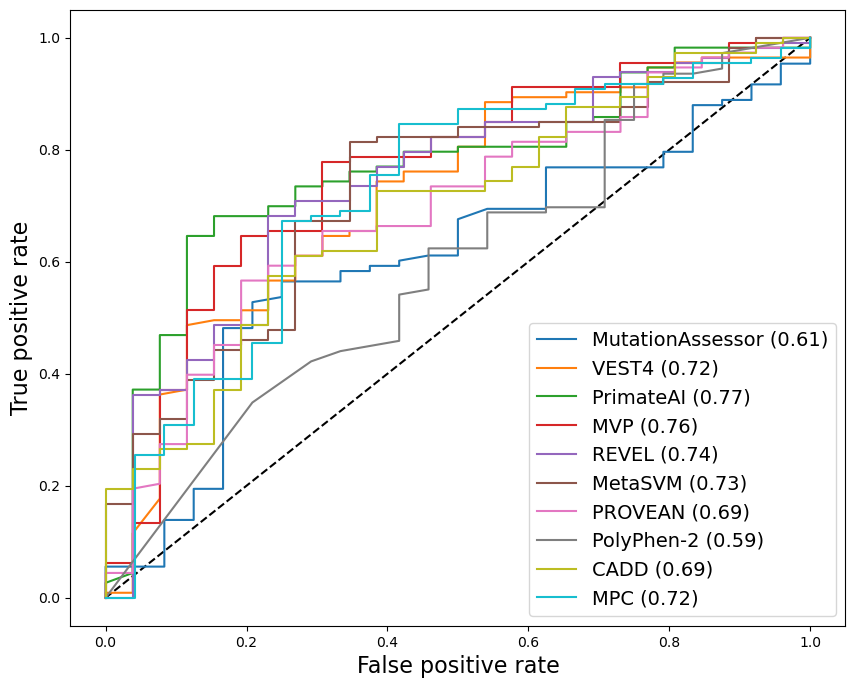

In [9]:
scores = np.append(MA_chd, MA_control)
y = np.append(np.repeat(1,len(MA_chd)), np.repeat(0,len(MA_control)))
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
precision, recall, thresholds_1 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(VEST4_chd, VEST4_control)
y = np.append(np.repeat(1,len(VEST4_chd)), np.repeat(0,len(VEST4_control)))
fpr2, tpr2, thresholds2 = roc_curve(y, scores, pos_label=1)
precision2, recall2, thresholds_2 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(primateAI_chd, primateAI_control)
y = np.append(np.repeat(1,len(primateAI_chd)), np.repeat(0,len(primateAI_control)))
fpr3, tpr3, thresholds3 = roc_curve(y, scores, pos_label=1)
precision3, recall3, thresholds_3 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(MVP_chd, MVP_control)
y = np.append(np.repeat(1,len(MVP_chd)), np.repeat(0,len(MVP_control)))
fpr4, tpr4, thresholds4 = roc_curve(y, scores, pos_label=1)
precision4, recall4, thresholds_4 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(REVEL_chd, REVEL_control)
y = np.append(np.repeat(1,len(REVEL_chd)), np.repeat(0,len(REVEL_control)))
fpr5, tpr5, thresholds5 = roc_curve(y, scores, pos_label=1)
precision5, recall5, thresholds_5 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(MSVM_chd, MSVM_control)
y = np.append(np.repeat(1,len(MSVM_chd)), np.repeat(0,len(MSVM_control)))
fpr6, tpr6, thresholds6 = roc_curve(y, scores, pos_label=1)
precision6, recall6, thresholds_6 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(PROVEAN_chd, PROVEAN_control)
y = np.append(np.repeat(1,len(PROVEAN_chd)), np.repeat(0,len(PROVEAN_control)))
fpr7, tpr7, thresholds7 = roc_curve(y, scores, pos_label=1)
precision7, recall7, thresholds_7 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(PP2_chd, PP2_control)
y = np.append(np.repeat(1,len(PP2_chd)), np.repeat(0,len(PP2_control)))
fpr8, tpr8, thresholds8 = roc_curve(y, scores, pos_label=1)
precision8, recall8, thresholds_8 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(CADD_chd, CADD_control)
y = np.append(np.repeat(1,len(CADD_chd)), np.repeat(0,len(CADD_control)))
fpr9, tpr9, thresholds9 = roc_curve(y, scores, pos_label=1)
precision9, recall9, thresholds_9 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(MPC_chd, MPC_control)
y = np.append(np.repeat(1,len(MPC_chd)), np.repeat(0,len(MPC_control)))
fpr10, tpr10, thresholds10 = roc_curve(y, scores, pos_label=1)
precision10, recall10, thresholds_10 = precision_recall_curve(y, scores, pos_label=1)


plt.figure(1, figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='MutationAssessor (%0.2f)' % auc(fpr,tpr))
plt.plot(fpr2, tpr2, label='VEST4 (%0.2f)' % auc(fpr2,tpr2))
plt.plot(fpr3, tpr3, label='PrimateAI (%0.2f)' % auc(fpr3,tpr3))
plt.plot(fpr4, tpr4, label='MVP (%0.2f)' % auc(fpr4,tpr4))
plt.plot(fpr5, tpr5, label='REVEL (%0.2f)' % auc(fpr5,tpr5))
plt.plot(fpr6, tpr6, label='MetaSVM (%0.2f)' % auc(fpr6,tpr6))
plt.plot(fpr7, tpr7, label='PROVEAN (%0.2f)' % auc(fpr7,tpr7))
plt.plot(fpr8, tpr8, label='PolyPhen-2 (%0.2f)' % auc(fpr8,tpr8))
plt.plot(fpr9, tpr9, label='CADD (%0.2f)' % auc(fpr9,tpr9))
plt.plot(fpr10, tpr10, label='MPC (%0.2f)' % auc(fpr10,tpr10))

plt.xlabel('False positive rate', color = 'black', fontsize=16) 
plt.ylabel('True positive rate', color = 'black', fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.savefig('figures/SuppFigure1A.pdf')

plt.show()

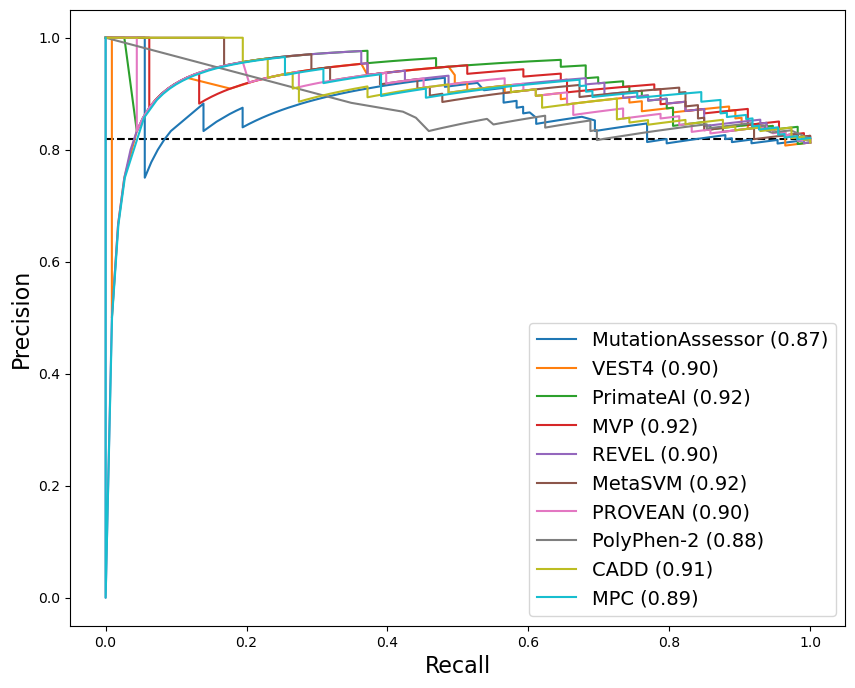

In [10]:
plt.figure(1, figsize=(10,8))
plt.plot([0, 1], [0.82, 0.82], 'k--')
plt.plot(recall, precision, label='MutationAssessor (%0.2f)' % auc(recall,precision))
plt.plot(recall2, precision2, label='VEST4 (%0.2f)' % auc(recall2,precision2))
plt.plot(recall3, precision3, label='PrimateAI (%0.2f)' % auc(recall3,precision3))
plt.plot(recall4, precision4, label='MVP (%0.2f)' % auc(recall4,precision4))
plt.plot(recall5, precision5, label='REVEL (%0.2f)' % auc(recall5,precision5))
plt.plot(recall6, precision6, label='MetaSVM (%0.2f)' % auc(recall6,precision6))
plt.plot(recall7, precision7, label='PROVEAN (%0.2f)' % auc(recall7,precision7))
plt.plot(recall8, precision8, label='PolyPhen-2 (%0.2f)' % auc(recall8,precision8))
plt.plot(recall9, precision9, label='CADD (%0.2f)' % auc(recall9,precision9))
plt.plot(recall10, precision10, label='MPC (%0.2f)' % auc(recall10,precision10))

plt.xlabel('Recall', color = 'black', fontsize=16) 
plt.ylabel('Precision', color = 'black', fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.savefig('figures/SuppFigure1B.pdf')

plt.show()

## Figure 1A

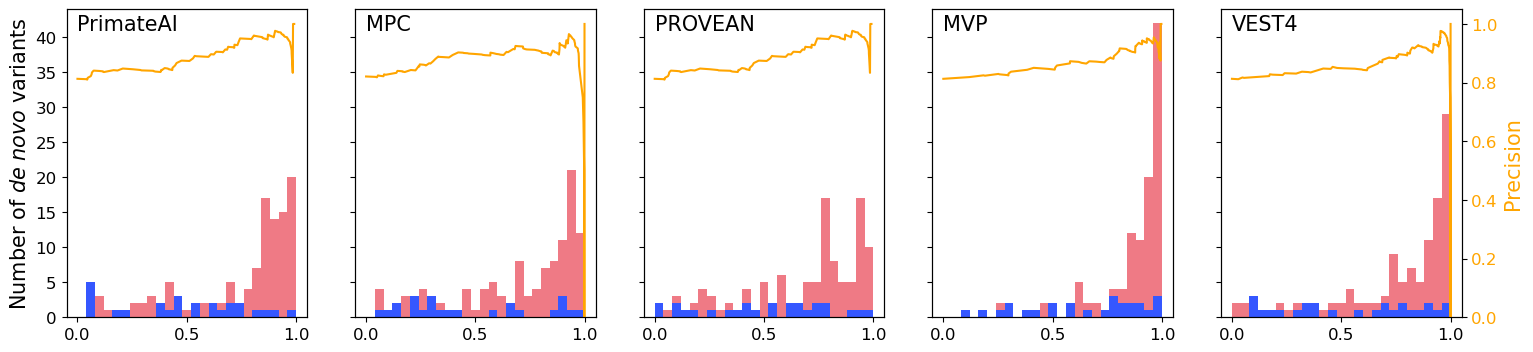

In [31]:
### Version with true positive rate

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(18,4))#, tight_layout=True)

plt.rcParams.update({'font.size': 12})
plt.ylim((0,44))

axs[0].set_ylabel('Number of $\\it{de}$ $\\it{novo}$ variants', color = 'black', fontsize=15) 

# We can set the number of bins with the `bins` kwarg
axs[0].hist(primateAI_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[0].hist(primateAI_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[0].text(0, 41, 'PrimateAI', fontsize=15)

ax2 = axs[0].twinx()  
ax2.plot(np.insert(thresholds_3, 0,0), precision3 , color = 'orange')
#ax2.plot(np.insert(thresholds_3, 0,0), recall3 , color = 'red')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[1].hist(MPC_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[1].hist(MPC_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[1].text(0, 41, 'MPC', fontsize=15)
ax2 = axs[1].twinx()  
ax2.plot(np.insert(thresholds_10, 0,0), precision10 , color = 'orange')
#ax2.plot(np.insert(thresholds_10, 0,0), recall10 , color = 'red')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[2].hist(PROVEAN_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[2].hist(PROVEAN_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[2].text(0, 41, 'PROVEAN', fontsize=15)
#axs[2].set_xlabel('Score percentile', color = 'black', fontsize=14) 
ax2 = axs[2].twinx()  
ax2.plot(np.insert(thresholds_3, 0,0), precision3 , color = 'orange') 
plt.ylim((0,1.05))
plt.yticks([]) 

axs[3].hist(MVP_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[3].hist(MVP_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[3].text(0, 41, 'MVP', fontsize=15)
ax2 = axs[3].twinx()
ax2.plot(np.insert(thresholds_4, 0,0), precision4, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[4].hist(VEST4_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[4].hist(VEST4_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[4].text(0, 41, 'VEST4', fontsize=15)
ax2 = axs[4].twinx()  
ax2.set_ylabel('Precision', color = 'orange', fontsize=15) 
ax2.plot(np.insert(thresholds_5, 0,0), precision5, color = 'orange')
ax2.tick_params(axis ='y', labelcolor = 'orange') 
plt.ylim((0,1.05))

plt.savefig('figures/Figure1A_top.pdf')

plt.show()

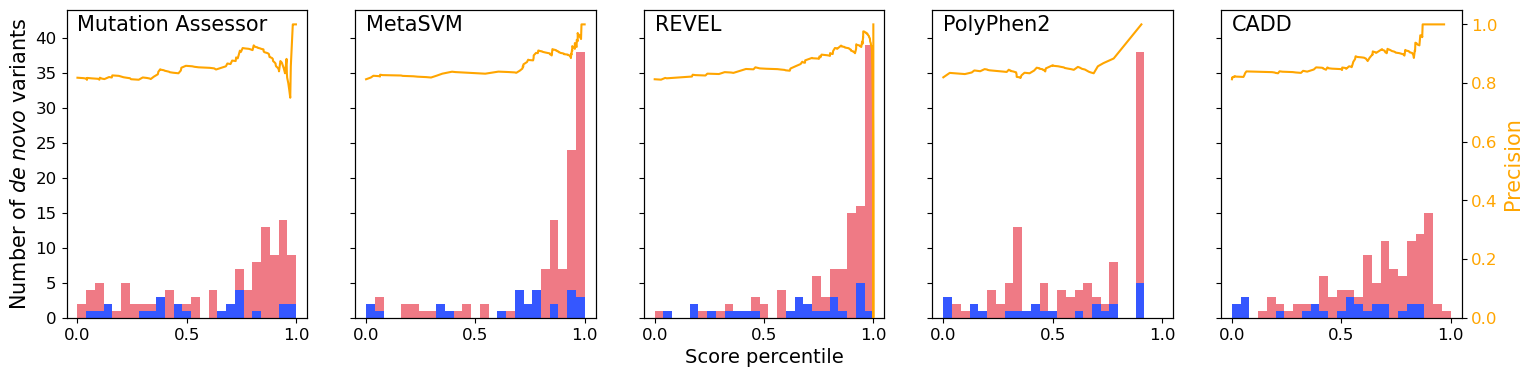

In [32]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(18,4))#, tight_layout=True)

plt.rcParams.update({'font.size': 12})
plt.ylim((0,44))

axs[0].set_ylabel('Number of $\\it{de}$ $\\it{novo}$ variants', color = 'black', fontsize=15) 

# We can set the number of bins with the `bins` kwarg
axs[0].hist(MA_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[0].hist(MA_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[0].text(0, 41, 'Mutation Assessor', fontsize=15)
ax2 = axs[0].twinx()  
ax2.plot(np.insert(thresholds_1, 0,0), precision, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[1].hist(MSVM_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[1].hist(MSVM_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[1].text(0, 41, 'MetaSVM', fontsize=15)
ax2 = axs[1].twinx()  
ax2.plot(np.insert(thresholds_6, 0,0), precision6, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[2].hist(REVEL_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[2].hist(REVEL_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[2].text(0, 41, 'REVEL', fontsize=15)
axs[2].set_xlabel('Score percentile', color = 'black', fontsize=14) 
ax2 = axs[2].twinx()  
ax2.plot(np.insert(thresholds_5, 0,0), precision5, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[3].hist(PP2_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[3].hist(PP2_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[3].text(0, 41, 'PolyPhen2', fontsize=15)
ax2 = axs[3].twinx()  
ax2.plot(np.insert(thresholds_8, 0,0), precision8, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 


axs[4].hist(CADD_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[4].hist(CADD_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[4].text(0, 41, 'CADD', fontsize=15)
ax2 = axs[4].twinx()  
ax2.set_ylabel('Precision', color = 'orange', fontsize=15) 
ax2.plot(np.insert(thresholds_9, 0,0), precision9, color = 'orange')
ax2.tick_params(axis ='y', labelcolor = 'orange') 
plt.ylim((0,1.05))

plt.savefig('figures/Figure1A_bottom.pdf')

plt.show()

## Bootstrap enrichment analysis

This is used for Figure 1B and Supplementary Figure 2

In [13]:
# chd 
np.random.seed(1)
missense_samples = np.unique(all_chd_scores['sample'])
boot_num = np.empty((20,1000))
for i in range(1000):
    boot = np.random.choice(3835,3835)
    counts = [0] * 20
    for j in boot:
        if j < len(missense_samples):
            #print(missense_samples[j])
            scores = all_chd_scores[all_chd_scores['sample'] == missense_samples[j]]['PrimateAI_rankscore']
            for s in scores:
                if s != None:
                    for k in range(20):
                        if s >= k / 20.0 and s < (k+1) / 20.0:
                            counts[k] += 1
    
    for k in range(20):
        boot_num[k][i] = counts[k]

In [14]:
#control
np.random.seed(100)
missense_samples_ctrl = np.unique(all_chd_control_scores['sample'])
boot_num_control = np.empty((20,1000))
for i in range(1000):
    boot = np.random.choice(2179,2179)
    counts = [0] * 20
    for j in boot:
        if j < len(missense_samples_ctrl):
            #print(missense_samples[j])
            scores = all_chd_control_scores[all_chd_control_scores['sample'] == missense_samples_ctrl[j]]['PrimateAI_rankscore']
            for s in scores:
                if s != None:
                    for k in range(20):
                        if s >= k / 20.0 and s < (k+1) / 20.0:
                            counts[k] += 1
    
    for k in range(20):
        boot_num_control[k][i] = counts[k]

In [15]:
interval = np.empty((2,20))
interval_ctrl = np.empty((2,20))
for i in range(20):
    lo, hi = np.percentile(np.array(boot_num[i]) / (0.033918181658547986 * 3835),(2.5,97.5))
    interval[0][i] = lo
    interval[1][i] = hi

for i in range(20):
    lo, hi = np.percentile(np.array(boot_num_control[i]) / (0.033918181658547986 * 2179),(2.5,97.5))
    interval_ctrl[0][i] = lo
    interval_ctrl[1][i] = hi

## Figure 1B

In [25]:
primateAI_chd_all = np.array(all_chd_scores['PrimateAI_rankscore'], dtype=float)
primateAI_control_all = np.array(all_chd_control_scores['PrimateAI_rankscore'], dtype=float)
primateAI_chd_all = primateAI_chd_all[np.isfinite(primateAI_chd_all)]
primateAI_control_all = primateAI_control_all[np.isfinite(primateAI_control_all)]

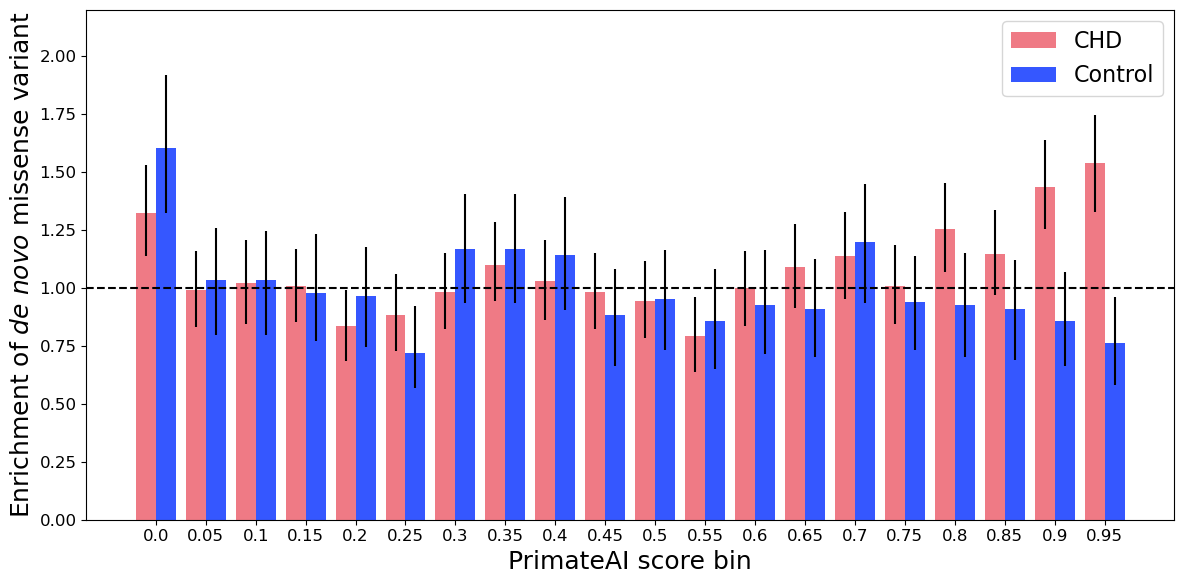

In [34]:
score_bin = []
chd_bin = []
control_bin = []
for i in range(0,20):
    score_bin.append((i) /20)
    chd_bin.append((sum(primateAI_chd_all > i/20) - sum(primateAI_chd_all > (i+1)/20) ) / (0.033918181658547986 *3835))
    control_bin.append((sum(primateAI_control_all > i/20) - sum(primateAI_control_all > (i+1)/20) ) / (0.033964594379751946 *2165))

    
errors = [abs(interval[0] - chd_bin), interval[1] - chd_bin]
errors_ctrl = [abs(interval_ctrl[0] - control_bin), interval_ctrl[1] - control_bin]
    


plt.rcParams.update({'font.size': 12})
x = np.arange(len(score_bin))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width / 2, chd_bin, width, label='CHD', yerr = errors, color = "#ef7a85")
rects3 = ax.bar(x + width / 2, control_bin, width, label='Control', yerr = errors_ctrl, color = "#3557ff")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enrichment of $\\it{de}$ $\\it{novo}$ missense variant', fontsize=18)
ax.set_xlabel('PrimateAI score bin', fontsize=18)
#ax.set_title('Mutation type')
ax.set_xticks(x)
ax.set_xticklabels(score_bin)
ax.set_ylim((0,2.2))
ax.legend(fontsize = 16)

ax.axhline(1, linestyle = '--', color = 'black')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height + 0.02),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


fig.tight_layout()

plt.savefig('figures/Figure1B.pdf')

plt.show()

## Supplementary Figure 2

In [27]:
### Interval for the variant groupings
interval_2 = np.empty((2,3))
interval_ctrl_2 = np.empty((2,3))

interval_2[0][0], interval_2[1][0] = np.percentile(np.array(boot_num[18] + boot_num[19]) / (0.033918181658547986 * 3835 * 2),(2.5,97.5))
interval_ctrl_2[0][0], interval_ctrl_2[1][0] = np.percentile(np.array(boot_num_control[18] + boot_num_control[19]) / (0.033918181658547986 * 2179 * 2),(2.5,97.5))
interval_2[0][1], interval_2[1][1] = np.percentile(np.array(boot_num[15] + boot_num[16] + boot_num[17]) / (0.033918181658547986 * 3835 * 3),(2.5,97.5))
interval_ctrl_2[0][1], interval_ctrl_2[1][1] = np.percentile(np.array(boot_num_control[15] + boot_num_control[16] + boot_num_control[17]) / (0.033918181658547986 * 2179 * 3),(2.5,97.5))
interval_2[0][2], interval_2[1][2] = np.percentile(np.sum(boot_num[:15], axis=0) / (0.033918181658547986 * 3835 * 15),(2.5,97.5))
interval_ctrl_2[0][2], interval_ctrl_2[1][2] = np.percentile(np.sum(boot_num_control[:15], axis=0) / (0.033918181658547986 * 2179 * 15),(2.5,97.5))


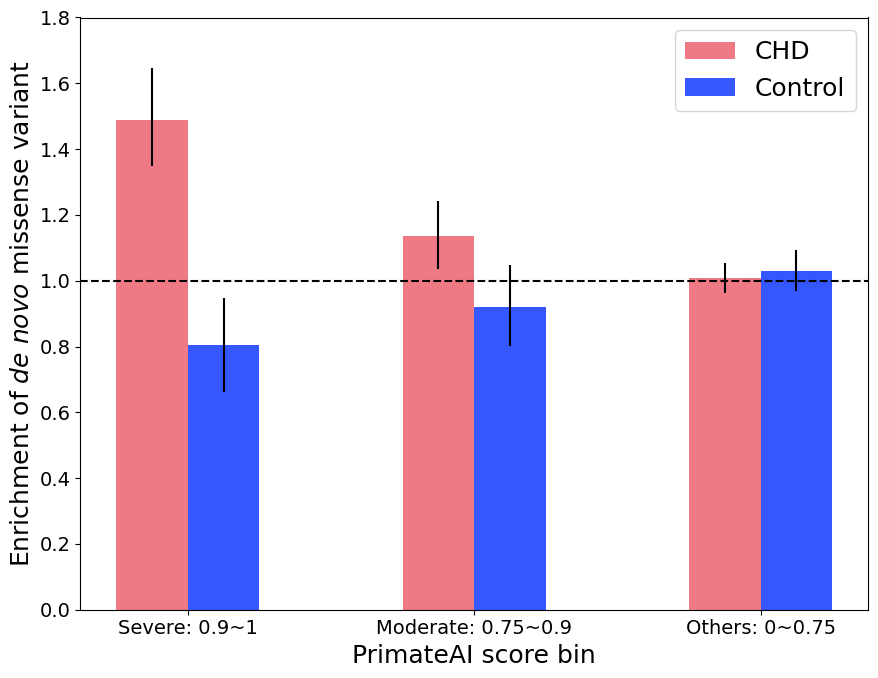

In [33]:
score_bin = ['Class 1', 'Class 2', 'others']
chd_bin = []
control_bin = []

chd_bin.append((sum(primateAI_chd_all > 0.9) ) / (0.033918181658547986 * 2 * 3835))
chd_bin.append((sum(primateAI_chd_all > 0.75) - sum(primateAI_chd_all > 0.9)) / (0.033918181658547986 * 3 * 3835))
chd_bin.append((sum(primateAI_chd_all > 0) - sum(primateAI_chd_all > 0.75 )) / (0.033918181658547986 * 15 * 3835))              
control_bin.append((sum(primateAI_control_all > 0.9) ) / (0.033918181658547986 * 2 * 2179))
control_bin.append((sum(primateAI_control_all > 0.75) - sum(primateAI_control_all > 0.9)) / (0.033918181658547986 * 3 * 2179))
control_bin.append((sum(primateAI_control_all > 0) - sum(primateAI_control_all > 0.75)) / (0.033918181658547986 * 15 * 2179))
              

errors = [abs(interval_2[0] - chd_bin), interval_2[1] - chd_bin]
errors_ctrl = [abs(interval_ctrl_2[0] - control_bin), interval_ctrl_2[1] - control_bin]

labels =  ['Severe: 0.9~1', 'Moderate: 0.75~0.9', 'Others: 0~0.75']

plt.rcParams.update({'font.size': 14})
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(9,7))
rects1 = ax.bar(x - width / 2, chd_bin, width, label='CHD', yerr = errors, color = "#ef7a85")
rects3 = ax.bar(x + width / 2, control_bin, width, label='Control', yerr = errors_ctrl, color = "#3557ff")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enrichment of $\\it{de}$ $\\it{novo}$ missense variant', fontsize=18)
ax.set_xlabel('PrimateAI score bin', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim((0,1.8))
ax.axhline(1, linestyle = '--', color = 'black')

ax.legend(fontsize=18)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),4)
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



fig.tight_layout()

plt.savefig('figures/SuppFigure2.pdf')

plt.show()